Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [9]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [18]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [19]:
print(df.shape)
df.head()

(423, 66)


,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df['overall'].describe()

count    421.000000
mean       3.620887
std        0.755718
min        1.000000
25%        3.100000
50%        3.800000
75%        4.100000
max        5.000000
Name: overall, dtype: float64

In [21]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [22]:
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [8]:
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [23]:
df['Date'].describe()

count           421
unique          169
top       8/30/2016
freq             29
Name: Date, dtype: object

In [92]:
# Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
cutoff_1 = pd.to_datetime('2017-01-01')
cutoff_2 = pd.to_datetime('2018-01-01')
train = df[df.Date < cutoff_1]
val = df[(df.Date >= cutoff_1) & (df.Date < cutoff_2)]
test  = df[df.Date >= cutoff_2]

In [29]:
# test = test.drop(columns=['Great'])

In [93]:
train.shape, val.shape, test.shape

((298, 67), (85, 67), (38, 67))

In [94]:
set(train.columns) - set(test.columns)

set()

In [32]:
target = 'Great' 
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [33]:
#Begin with baselines for classification.

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [34]:
majority_class

False

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5906040268456376

In [36]:
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

In [38]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Meat:filling', 'Salsa', 'Tortilla']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...  
linear_reg.predict(X_val_imputed)

array([ 0.24048049,  0.5992804 ,  0.49768337,  0.5777389 ,  0.01221872,
        0.30633142,  0.59816278,  0.53500272,  0.39935002,  0.71999273,
        0.65108296,  0.18248701, -0.01754331,  0.44102793,  0.95204978,
        0.31944823,  0.56840075,  0.33256504,  0.50661198,  0.95204978,
        0.65820397,  0.65820397,  0.34188656,  0.21451374,  0.57394361,
        0.56840075,  0.83426537,  0.30606454,  0.37544388,  0.34220729,
        0.70687592,  0.43168978,  0.13541997,  0.45211366,  0.08698163,
        0.13404867,  0.64149456,  0.58882463,  0.43345398,  0.59639857,
        0.48793568,  0.5777389 ,  0.60750093,  0.54745974,  0.6140965 ,
        0.36231044,  0.28564066,  0.59816278,  0.39586776,  0.21451374,
        0.13404867,  0.41680876,  0.6526611 ,  0.6526611 ,  0.39991329,
        0.36056286,  0.21451374,  0.4765997 ,  0.64886581,  0.48239281,
       -0.33233013,  0.24296451,  0.00288057,  0.50281669,  0.42235163,
        0.56840075,  0.59816278,  0.94096406,  0.50661198,  0.51

In [41]:
# Get coefficients
pd.Series(linear_reg.coef_, features)

Meat:filling    0.160930
Salsa           0.131168
Tortilla        0.142254
dtype: float64

In [42]:
test_case = [[4.0, 3.0, 2.0]] 
linear_reg.predict(test_case)

array([0.23319005])


### Logistic Regression!


In [54]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

#this is already better then baseline!

Validation Accuracy 0.7294117647058823


In [55]:
# The predictions look like this
log_reg.predict(X_val_imputed)
#discrete classes!

array([False,  True, False,  True, False, False,  True,  True, False,
        True,  True, False, False, False,  True, False,  True, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True, False, False, False, False, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False,  True, False,  True, False,
        True, False, False,  True])

In [56]:
log_reg.predict(test_case)

array([False])

In [57]:
log_reg.predict_proba(test_case)

array([[0.85301492, 0.14698508]])

In [58]:
log_reg.coef_[0]

array([1.13133031, 0.84825434, 0.92101098])

In [59]:
log_reg.intercept_

array([-10.67055218])

In [60]:
# The logistic sigmoid "squishing" function, implemented to accept numpy arrays
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

In [61]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.14698508]])

In [62]:
train.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,Donato's taco shop,California,2016-01-18,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Oscar's Mexican food,California,2016-01-24,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Oscar's Mexican food,Carnitas,2016-01-24,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Oscar's Mexican food,Carne asada,2016-01-24,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,Pollos Maria,California,2016-01-27,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [63]:
features = ['Meat:filling', 'Salsa', 'Tortilla','Hunger','Temp','Cheese','Beef']

In [64]:
target = 'Great'
x_train = train[features]
y_train = train[target]

x_val=val[features]
y_val=val[target]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((298, 7), (298,), (85, 7), (85,))

In [65]:
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [68]:
# x_train.head()
x_val.head()

,Meat:filling,Salsa,Tortilla,Hunger,Temp,Cheese,Beef
301,3.5,1.5,4.0,NaN,4.5,NaN,NaN
302,NaN,4.2,4.0,NaN,2.0,NaN,NaN
303,3.7,4.3,3.0,3.9,4.5,NaN,NaN
304,4.0,4.0,3.5,4.0,4.0,NaN,NaN
305,3.0,2.0,2.5,3.5,4.5,NaN,NaN


In [69]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(x_train)
X_val_encoded = encoder.transform(x_val)
X_train_encoded.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Meat:filling,Salsa,Tortilla,Hunger,Temp,Cheese_x,Cheese_nan,Cheese_X,Beef_x,Beef_nan,Beef_X
0,4.0,4.0,3.0,3.0,5.0,1,0,0,1,0,0
1,2.0,3.5,2.0,3.5,3.5,1,0,0,1,0,0
2,4.5,3.0,3.0,1.5,2.0,0,1,0,0,1,0
3,4.0,4.0,3.0,2.0,2.0,0,1,0,1,0,0
4,4.5,2.5,4.0,4.0,5.0,1,0,0,1,0,0


In [70]:
X_val_encoded.head()

,Meat:filling,Salsa,Tortilla,Hunger,Temp,Cheese_x,Cheese_nan,Cheese_X,Beef_x,Beef_nan,Beef_X
301,3.5,1.5,4.0,NaN,4.5,0,1,0,0,1,0
302,NaN,4.2,4.0,NaN,2.0,0,1,0,0,1,0
303,3.7,4.3,3.0,3.9,4.5,0,1,0,0,1,0
304,4.0,4.0,3.5,4.0,4.0,0,1,0,0,1,0
305,3.0,2.0,2.5,3.5,4.5,0,1,0,0,1,0


In [71]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [72]:
X_train_imputed[:5] 

array([[4. , 4. , 3. , 3. , 5. , 1. , 0. , 0. , 1. , 0. , 0. ],
       [2. , 3.5, 2. , 3.5, 3.5, 1. , 0. , 0. , 1. , 0. , 0. ],
       [4.5, 3. , 3. , 1.5, 2. , 0. , 1. , 0. , 0. , 1. , 0. ],
       [4. , 4. , 3. , 2. , 2. , 0. , 1. , 0. , 1. , 0. , 0. ],
       [4.5, 2.5, 4. , 4. , 5. , 1. , 0. , 0. , 1. , 0. , 0. ]])

In [73]:
X_val_imputed[:5]

array([[3.5       , 1.5       , 4.        , 3.4452862 , 4.5       ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        ],
       [3.52886986, 4.2       , 4.        , 3.4452862 , 2.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        ],
       [3.7       , 4.3       , 3.        , 3.9       , 4.5       ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        ],
       [4.        , 4.        , 3.5       , 4.        , 4.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        ],
       [3.        , 2.        , 2.5       , 3.5       , 4.5       ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        ]])

In [74]:
# turn to a dataframe
pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)

,Meat:filling,Salsa,Tortilla,Hunger,Temp,Cheese_x,Cheese_nan,Cheese_X,Beef_x,Beef_nan,Beef_X
0,4.0,4.00000,3.0,3.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2.0,3.50000,2.0,3.5,3.5,1.0,0.0,0.0,1.0,0.0,0.0
2,4.5,3.00000,3.0,1.5,2.0,0.0,1.0,0.0,0.0,1.0,0.0
3,4.0,4.00000,3.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4.5,2.50000,4.0,4.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
293,4.2,3.00000,4.0,3.0,1.5,0.0,1.0,0.0,0.0,1.0,0.0
294,2.5,3.00000,4.5,3.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0
295,1.4,2.20000,3.5,4.0,2.5,0.0,0.0,1.0,0.0,0.0,1.0
296,3.5,2.00000,4.0,4.0,4.5,0.0,1.0,0.0,0.0,0.0,1.0


In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [76]:
X_train_scaled[:5]

array([[ 0.4582244 ,  0.72124523, -0.59316238, -0.52430658,  1.34069563,
         1.20946679, -1.        , -0.32203059,  1.13679712, -0.87966444,
        -0.38230073],
       [-1.48698931,  0.18727406, -1.84902306,  0.0644233 , -0.21386677,
         1.20946679, -1.        , -0.32203059,  1.13679712, -0.87966444,
        -0.38230073],
       [ 0.94452783, -0.34669711, -0.59316238, -2.29049622, -1.76842918,
        -0.82681063,  1.        , -0.32203059, -0.87966444,  1.13679712,
        -0.38230073],
       [ 0.4582244 ,  0.72124523, -0.59316238, -1.70176634, -1.76842918,
        -0.82681063,  1.        , -0.32203059,  1.13679712, -0.87966444,
        -0.38230073],
       [ 0.94452783, -0.88066828,  0.66269829,  0.65315318,  1.34069563,
         1.20946679, -1.        , -0.32203059,  1.13679712, -0.87966444,
        -0.38230073]])

In [77]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [79]:
y_pred = model.predict(X_val_scaled)
accuracy_score(y_val, y_pred)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.7294117647058823


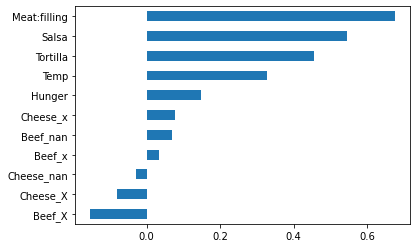

In [80]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh(); #bar charts

In [81]:
X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)

y_pred = model.predict(X_test_scaled)

In [84]:
y_pred

array([ True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False, False, False,  True,  True,  True,  True, False, False,
        True,  True,  True, False,  True, False, False,  True, False,
        True,  True])

In [95]:
y_test=test[target]

In [96]:
accuracy_score(y_test, y_pred)

0.7631578947368421